# Figure C: the tolerance parameter for Huron's typology

In this notebook we search for the value of the tolerance parameter for which Huron's typology has maximal entropy.
That is, for which the classes are as big as possible. We do do this by a simple grid search.

In [1]:
# Import 
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats
import seaborn as sns
import json
import sys

sys.path.append('../')
from helpers import cm2inch, title, show_num_contours, load_datasets
from src.typology import search_huron_tolerance_param
from src.typology import huron_contour_type
matplotlib.style.use('styles.mplstyle')

ModuleNotFoundError: No module named 'src.typology'

In [ ]:
# Load all data
dfs, contours = load_datasets()

## Parameter optimization using grid search

We look for the optimal tolerance parameter $\epsilon$ using a simple grid search. 
For $\epsilon \in \{0, 0.1, 0.2, \dots, 10\}$ we compute the type assignments of all contours, and entropy of the resulting type distribution. 
The function implementing the grid search is `src.typology.seach_huron_tolerance_param`.
All results are stored in a JSON file so we can plot the results later.


In [3]:
if False:
    param_search = {}
    grid = np.arange(0, 10.1, .1)
    for dataset_id in dfs.keys():
        df = dfs[dataset_id]
        contours = df.iloc[:, 6:].values
        index, tolerances, entropies, freqs, types = search_huron_tolerance_param(contours, tolerances=grid)
        param_search[dataset_id] = {
            'tolerance': float(tolerances[index]),
            'entropy': float(entropies[index]),
            'index': int(index),
            'tolerances': list(tolerances),
            'entropies': list(entropies),
            'frequencies': freqs.tolist(),
            'types': types
        }
    with open('../results/tolerance-parameter-search.json', 'w') as handle:
        json.dump(param_search, handle, indent=4)

Here is a quick plot of the entropy as a function of the tolerance in the three datasets

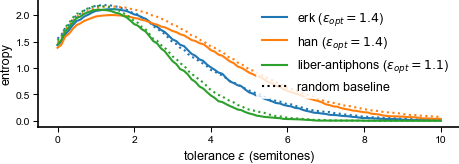

In [4]:
plt.figure(figsize=cm2inch(8, 3))
param_search = json.load(open('../results/tolerance-parameter-search.json', 'r'))
for dataset_id in ['erk', 'han', 'liber-antiphons']:
    params = param_search[dataset_id]
    optimum = np.round(params['tolerance'], 1)
    l, = plt.plot(params['tolerances'], params['entropies'], 
             label=f'{dataset_id} ($\epsilon_{{opt}} = {optimum}$)', lw=1)
    
    params = param_search[dataset_id+'-random']
    optimum = np.round(params['tolerance'], 1)
    plt.plot(params['tolerances'], params['entropies'], ':', lw=1, color=l.get_color())

plt.plot([0], [0], 'k:', label='random baseline', lw=1)
plt.legend()
plt.ylabel('entropy')
plt.xlabel('tolerance $\epsilon$ (semitones)');
plt.savefig(f'../figures/figS03-entropies.pdf')

### Combined plot of parameter search and type frequencies

In [5]:
order = {
    'descending': 'desc',
    'horizontal-descending': 'h-desc',
    'convex': 'convex',
    'descending-horizontal': 'desc-h',
    'horizontal': 'horiz',
    'ascending-horizontal': 'asc-h',
    'concave': 'concave',
    'ascending': 'asc',
    'horizontal-ascending': 'h-asc',

}

/Users/Bas/repos/papers/fma-melodic-contour-typology/env/lib/python3.7/site-packages/ipykernel_launcher.py:81: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


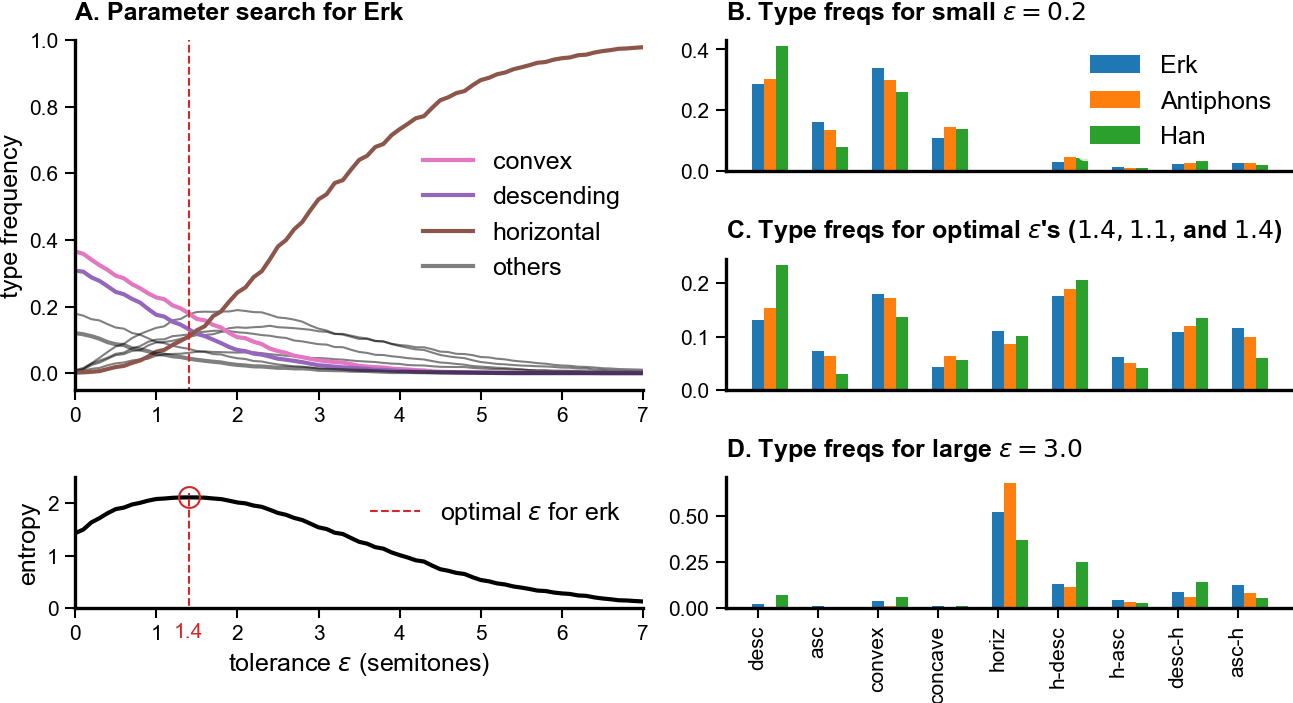

In [6]:
def plot_param_search_combined(param_search, all_param_search, title=None):
    tol = param_search['tolerance']
    tolerances = param_search['tolerances']
    entropies = param_search['entropies']
    entropy = param_search['entropy']
    freqs = pd.DataFrame(param_search['frequencies'], index=param_search['types'])

    plt.figure(figsize=cm2inch(12,6.5))
    ax1 = plt.subplot2grid((3, 2), (0, 0), rowspan=2)
    
    # Frequencies
    
    for label, ys in freqs.iterrows():
        if label not in ['horizontal', 'descending', 'convex', 'concave']:
            plt.plot(tolerances, ys, 'k-', lw=.5, ms=4, alpha=.5)
    plt.plot(tolerances, freqs.loc['convex', :], '-', lw=1, color='C6', label='convex')
    plt.plot(tolerances, freqs.loc['descending', :], '-', lw=1, color='C4', label='descending')
    plt.plot(tolerances, freqs.loc['horizontal', :], '-', lw=1, color='C5', label='horizontal')
    plt.plot(tolerances, freqs.loc['concave', :], 'k-', lw=1, ms=4, alpha=.5, label='others')

    plt.plot([tol, tol], [-1, 1], '--', color='C3', lw=.5)
    plt.ylim(-.05, 1)
    plt.xlim(0, 7)
    plt.ylabel('type frequency')
    plt.title('A. Parameter search for Erk', ha='left', x=0)
    plt.legend()
    
    
    # Entropies
    
    ax2 = plt.subplot2grid((3, 2), (2, 0), sharex=ax1)
    plt.plot(tolerances, entropies, 'k-', lw=1)
    plt.plot(tol, entropy, 'o', markerfacecolor="None", ms=5, color='C3', markeredgewidth=.5)
    plt.plot([tol, tol], [-1, 2.2], '--', color='C3', lw=.5, label='optimal $\epsilon$ for erk')
    plt.gca().text(tol, -.27, f'{tol:.1f}', color='C3', va='top', ha='center', size=5)
    plt.ylim(0, 2.5)
    plt.legend()
    plt.ylabel('entropy')
    plt.xlabel('tolerance $\epsilon$ (semitones)')
    
    
    def bar_plot(tolerance, dataset_id='erk',
                 width=.2, delta=0, label=None, color=None,
                 param_search=all_param_search):
        if tolerance == 'optimal':
            tolerance = param_search[dataset_id]['tolerance'] 
        index = param_search[dataset_id]['tolerances'].index(tolerance)
        freqs = np.array(param_search[dataset_id]['frequencies'])[:, index]
        plt.bar(np.arange(9) + delta, freqs, width=width, label=label, color=color)
        plt.xticks([])

    # Type frequencies small epsilon

    ax1 = plt.subplot2grid((3, 2), (0, 1))
    bar_plot(0.2, label='Erk', color='C0')
    bar_plot(0.2, 'liber-antiphons', label='Antiphons', delta=0.2, color='C1')
    bar_plot(0.2, 'han', delta=0.4, label='Han', color='C2')
    plt.legend()
    plt.title(f'B. Type freqs for small $\epsilon=0.2$', ha='left', x=0)

    # Type frequencies optimal epsilon

    ax2 = plt.subplot2grid((3, 2), (1, 1), sharex=ax1)
    bar_plot('optimal')
    bar_plot('optimal', 'liber-antiphons', delta=0.2)
    bar_plot('optimal', 'han', delta=.4)
    tol_erk = np.round(all_param_search['erk']['tolerance'], 1)
    tol_ant = np.round(all_param_search['liber-antiphons']['tolerance'], 1)
    tol_han = np.round(all_param_search['han']['tolerance'], 1)
    plt.title(f'C. Type freqs for optimal $\epsilon$\'s (${tol_erk}, {tol_ant}$, and ${tol_han}$)', ha='left', x=0)
    
    # Type frequencies large epsilon

    ax3 = plt.subplot2grid((3, 2), (2, 1))
    bar_plot(3)
    bar_plot(3, 'liber-antiphons', delta=0.2)
    bar_plot(3, 'han', delta=0.4)
    plt.title(f'D. Type freqs for large $\epsilon=3.0$', ha='left', x=0)
    labels = [order[t] for t in all_param_search['erk']['types']]
    plt.xticks(np.arange(9), labels, rotation=90);
    plt.tight_layout()

plot_param_search_combined(param_search['erk'], param_search)
plt.savefig(f'../figures/fig02-effect-tolerance-parameter.pdf')